In [ ]:
"""Licensed under the Apache License, Version 2.0."""

# Note due to random number generation in the underlying libraries, most notably 
# networkx, there are slight differences between results from running this colab
# and those seen in the manuscript.

import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from IPython import display

import plotnine as p9

# Library of analysis code common to experiments.
import protseq_analysis

In [ ]:
# Download the dataset from:
# Jess, Phillip (2021), “ProtSeq Data”, Mendeley Data, V1, doi: 10.17632/f9hdn5xc3v.1
# https://data.mendeley.com/datasets/f9hdn5xc3v/1

!wget https://data.mendeley.com/public-files/datasets/f9hdn5xc3v/files/3590fc8d-f47e-4199-982a-45871305178e/file_downloaded -O "Six cycle DNA_DNA BCS base calls.fastq.gz"
!wget https://data.mendeley.com/public-files/datasets/f9hdn5xc3v/files/ae9dfef2-af3f-4592-a895-519b8013f6c8/file_downloaded -O "Six cycle DNA_DNA BCS undertermined calls.fastq.gz"

In [ ]:
FEATURE_DELIM = ':'
TAG_PREFIX = 'S_'
MATCH_STR = 'SA'

In [ ]:
expt_dict = {
    'base': ['Six cycle DNA_DNA BCS base calls.fastq.gz'],
    'undertermined': ['Six cycle DNA_DNA BCS undertermined calls.fastq.gz'],
}

DNA_BINDER_DICT = {'SP12':'SA12', 'SP11':'SA11', 'SP10':'SA10', 'SP13':'SA13'} # These are the three standard DNA:DNA binder/target pairs. Update if new DNA:DNA binders are used

component_names_str = '''
BCS_Fd1_SP12	AACAC
BCS_Fd2_SP10	TCACA
BCS_Fd3_SP11	TTCAG
BCS_Fd7_NULL	ATCAAGGC
BCS_Fd8_SP13	CTAGTACG
BCS.SA10-1	TACCAAGA
BCS.SA11-1	TGAGTATC
BCS.SA12-1	GCTGTTCA
BCS.SA5_Random-1	TGAGCCTT
BCS.SA13-1	TTCGTAAC
BCS.SA10-2	TGTATAGT
BCS.SA11-2	AGGGTAAT
BCS.SA12-2	TTCACCAG
BCS.SA5_Random-2	AAATCGGA
BCS.SA13-2	TGATACGA
BCS.SA10-3	TGAACTTG
BCS.SA11-3	ACTTTACC
BCS.SA12-3	ATCTGAGC
BCS.SA5_Random-3	GGTCTCTA
BCS.SA13-3	CCTTCATA
BCS.SA10-4	TAGTCCAC
BCS.SA11-4	GCCATATA
BCS.SA12-4	CCTCTCAT
BCS.SA5-4	GGCTATAG
BCS.SA13-4	GGAATCAA
BCS.SA10-5	CACGAAAT
BCS.SA11-5	TCTTTCTA
BCS.SA12-5	ATGAGAAG
BCS.SA5-5	ATTCGATG
BCS.SA13-5	ATAGTCCT
BCS.SA10-6	ACTTACAC
BCS.SA11-6	TGACTAGT
BCS.SA12-6	GGTCGTTA
BCS.SA5-6	TTCTATCC
BCS.SA13-6	TTCAAACA
BCS.SA_Null	TACCATGG
BCS4_DirectSeqSA_BC	AGACTCAG
BCS4_DirectSeqSA_Missed	CTGCGCCTATACGAATT
NGS_Adapt	GTATG
BS_Bridge	CGTTATC
BS_Base	CATCAGCTCGCAGTCG
'''
subseqs, component_dict, seq_rev_comp_dict = protseq_analysis.get_subseqs_from_component_names(component_names_str)

In [ ]:
foundation_dict = {}
non_Fd_components = [component for component in component_dict.values() if protseq_analysis.FOUNDATION_SUBSTR not in component]

for component in component_dict.values():
  if protseq_analysis.FOUNDATION_SUBSTR in component:
    binder_match_unit = component.split('_')[-1]
    if binder_match_unit == 'NULL':
      continue
    binder_match_str = '.' + DNA_BINDER_DICT[binder_match_unit]
    foundation_dict[component] = [non_fd_comp for non_fd_comp in non_Fd_components if (binder_match_str in non_fd_comp)]


In [ ]:
SEQS_TO_READ = 100000000 # Number of sequences
DIST_FOR_CLUSTERING = 0
N_COMMON = 50000000
full_df = protseq_analysis.read_fastqs_for_experiment(
    expt_dict, num_reads=SEQS_TO_READ, subseqs=subseqs, n_common=N_COMMON, 
    dist_for_clustering=DIST_FOR_CLUSTERING)

In [ ]:
cycle_dfs, cycle_correspondence = protseq_analysis.foundation_partner_cycle_table(full_df, foundation_dict,
                                                         component_dict, cycles_to_check=6, heatmap=False,
                                                         allow_overlaps=False)

##Plotting and Tables

## Produce stacked histogram and counts table

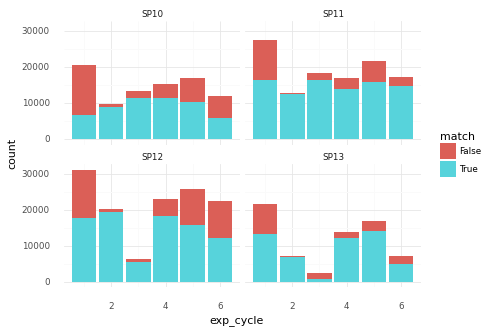

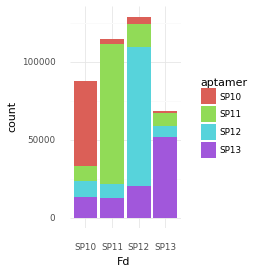

In [ ]:
def convert_cycle_dfs_to_stacked_hists(cycle_dfs, foundation_dict, 
                                      min_cycle, max_cycle):
  ''' Generate stacked histograms figures figures for multi-cycle runs.'''
  
  # Generate dataframe based on expected cycle
  foundations = []
  aptamers = []
  counts = []
  exp_cycles = []
  matches = []
  for i in range (min_cycle, max_cycle+1):
    cycle_df = cycle_dfs[i]
    for col in cycle_df.columns:
      for key, values in foundation_dict.items():
        aptamer = key.split('_')[-1]
        for val in values:
          # Tag association foundation target with corresponding aptamer
          tag = col.split('_')[-1]
          foundations.append(tag)
          aptamers.append(aptamer)
          exp_cycle = int(val[-1])
          count = cycle_df[col].loc[val]
          exp_cycles.append(exp_cycle)
          counts.append(count)
          matches.append(tag == aptamer)

  exp_plot_df = pd.DataFrame.from_dict({'Fd': foundations,
                          'aptamer': aptamers,
                          'count': counts,
                          'exp_cycle': exp_cycles,
                          'match': matches,})
  
  exp_plot_agg_df = exp_plot_df.groupby(
      ['Fd', 'aptamer', 'exp_cycle', 'match']).sum().reset_index()

  p = (p9.ggplot(exp_plot_agg_df[exp_plot_agg_df['Fd'] != 'Foundation'], 
                p9.aes('exp_cycle', 'count', fill='match')) + 
      p9.geom_bar(stat='identity', position='stack') + p9.facet_wrap('~Fd') +
        p9.theme_minimal())
                
  p.draw()

  # Generate dataframe based on "observed" cycle  
  foundations = []
  matches = []
  aptamers = []
  counts = []
  cycles = []
  for i in range (min_cycle, max_cycle+1):
    cycle_df = cycle_dfs[i]
    for col in cycle_df.columns:
      for key, values in foundation_dict.items():
        cycle_matches = [val for val in values if int(val[-1]) == i]
        cycle_mismatches =  [val for val in values if int(val[-1]) != i]
        aptamer = key.split('_')[-1]

        # Set placeholders to allow for two rows:
        #   1. Calculate when the expected cycle matches observed cycle
        #   2. Calculate when expected cycle mismatches observed cycle
        foundations += [col.split('_')[-1]]*2
        aptamers += [aptamer]*2
        cycles += [i]*2  
        
        # Add in match/mismatch flags and counts.
        matches += [True]
        matches += [False]
        counts += [cycle_df[col].loc[cycle_matches].sum()]
        counts += [cycle_df[col].loc[cycle_mismatches].sum()]
          
  plot_df = pd.DataFrame.from_dict({'Fd': foundations,
                          'match': matches,
                          'aptamer': aptamers,
                          'count': counts,
                          'cycle': cycles})
  
  # Aggregate based on 'Fd' and 'aptamer'
  # This ignores cycle information and corresponding matching cycle information.
  plot_agg_df = plot_df.groupby(['Fd', 'aptamer']).sum()[['count']].reset_index()

  p = (p9.ggplot(plot_agg_df[plot_agg_df['Fd'] != 'Foundation'], 
                 p9.aes('Fd', 'count', fill='aptamer')) + 
                 p9.geom_bar(stat='identity', position='stack') +
        p9.theme_minimal() + p9.theme(figure_size=[2, 4]))
                 
  p.draw()   

  return exp_plot_agg_df
        
exp_plot_agg_df = convert_cycle_dfs_to_stacked_hists(cycle_dfs, foundation_dict, 1, 6)


In [ ]:
# Drop empty foundations and produce table
six_cycle_table_df = exp_plot_agg_df[exp_plot_agg_df.Fd != 'Foundation']  
six_cycle_table_df.pivot(index=['aptamer', 'exp_cycle'], columns=['Fd'], 
                         values='count').astype(int)

Fd                  SP10   SP11   SP12   SP13
aptamer exp_cycle                            
SP10    1           6539   2096   1009    885
        2           8833    116    347    107
        3          11316    155    298    179
        4          11440    317    595    242
        5          10404    236   1221    178
        6           5828    327   1429    257
SP11    1           4883  16295   5545   5520
        2            264  12519    314    113
        3            425  16514    497    189
        4            614  13933   1218    400
        5           1422  15862   3143    839
        6           2207  14769   4215   1333
SP12    1           3003   2823  17818   1785
        2            447    218  19335    178
        3           1556   1745   5446   1227
        4           1658   1267  18392   1094
        5           2033   2202  15735   1627
        6           1398    957  12293    675
SP13    1           6078   6384   6886  13344
        2            157     67    275   6867
        3             51     11    126    702
        4           1616   1548   2900  12098
        5           3172   3536   5659  14169
        6           2442   1188   4550   4972

## Experiment Cycle, Yield Line Plot

In [ ]:
def check_n_name_match(label_str):  
  '''Determine the number of exact matches for a particular foundation.'''
  fd_str_list = str(label_str).split(';')
  fd_str_list = [elem for elem in fd_str_list if 'SA' in elem or 'SP' in elem]
  if len(fd_str_list) > 0 and 'Fd' in fd_str_list[0]:
    tag = fd_str_list[0].split('_')[-1]
    # Get last two characters since numbers are  2-digits.
    match_tag = '.SA'+tag[-2:]+'-'  
    matches = []
    for elem in fd_str_list[1:]:
      if match_tag not in elem:
        matches.append(0)
      else:
        matches.append(int(elem.split('-')[-1]))
    n_matches = 0
    #print (matches)
    for i, match in enumerate(matches):
      if i < 5 and match == i+1:
        n_matches = i+1
      elif match == (i+1)-6:
        n_matches = i+1
      else:
        return n_matches
    return n_matches
  
def get_foundation_name(label_str):  
  '''From the match string identify the foundation.'''
  fd_str_list = str(label_str).split(';')
  fd_str_list = [elem for elem in fd_str_list if 'SP' in elem]
  if len(fd_str_list) > 0 and 'Fd' in fd_str_list[0]:
    tag = fd_str_list[0].split('_')[-1]
    return tag
  return None

In [ ]:
def make_count_vs_cycle_line_plot(full_df):
  fds = []
  counts = []
  cycles = []
  bcs_nonzero_df = full_df[full_df['check_n_name_match'] > 0]
  for fd in full_df.base_foundation.unique():
    temp_df = bcs_nonzero_df[(bcs_nonzero_df['base_foundation'] == fd)]
    for i in range (1, 13): # Optional limit to check 12-cycle experiments.
      count =  temp_df[(temp_df['check_n_name_match'] >= i)]['count'].sum()
      counts.append(count)
      cycles.append(i)
      fds.append(fd)
  line_df = pd.DataFrame.from_dict({'Fd': fds, 'count': counts, 
                                    'Experimental Cycle Number': cycles})
  line_df['Log Count'] = np.log(line_df['count']+1)

  max_cycles = max(line_df[line_df['count'] > 0]['Experimental Cycle Number'])
  plt.figure(figsize=(float(max_cycles) / 2., 6))
  sns.lineplot(data=line_df[line_df['Experimental Cycle Number'] <= max_cycles], 
               x='Experimental Cycle Number', y='Log Count', hue='Fd')
  plt.legend()
  return line_df

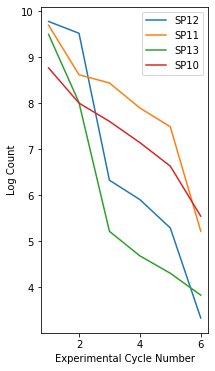

In [ ]:
# Note the affect of the random number generator variance is most apparent in
# the low counts of the last cycle in the line plot figure below. 
full_df['base_foundation'] = full_df.ordered_foundation_labels.apply(get_foundation_name)
full_df['check_n_name_match'] = full_df.ordered_foundation_labels.apply(check_n_name_match)
_ = make_count_vs_cycle_line_plot(full_df)